In [18]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread
import imageio
print(os.listdir("/content/drive/MyDrive/brain tumor segmentation/huzaifa_data"))

['Script', 'DataSetBrats', 'experiments', 'Prepared_MRI_data', 'Models', 'Report', 'spade_data']


In [117]:
'''def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        #path = glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/%s/%s' % ('spade_data', 'train'))
        path = glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/%s/%s/*' % (dataset_name,data_type))

        batch_images = np.random.choice(path, size=batch_size)
        #img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :] 
            else:  
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution 
            #img_A = transform.resize(img_A, img_res)  #Ground Truth image
            #img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
            
        
        imgs_A = np.array(imgs_A)
        imgs_B = np.array(imgs_B)

        return imgs_A, imgs_B'''

'def load_data(dataset_name,batch_size=1, is_val=False):\n        data_type = "train" if not is_val else "val"\n        #path = glob(\'/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/%s/%s\' % (\'spade_data\', \'train\'))\n        path = glob(\'/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/%s/%s/*\' % (dataset_name,data_type))\n\n        batch_images = np.random.choice(path, size=batch_size)\n        #img_res=(128,128)\n        imgs_A = []\n        imgs_B = []\n        for img_path in batch_images:\n            img = imread(img_path)\n\n            h, w, _ = img.shape\n            _w = int(w/2)\n            # because in the edges2shoes and maps dataset the input image comes before the ground truth.\n            if (dataset_name=="edges2shoes" or dataset_name=="maps"):\n                img_A, img_B = img[:, _w:, :],img[:, :_w, :] \n            else:  \n                img_A, img_B = img[:, :_w, :], img[:, _w:, :]\n            # decreasing the resolution \n   

In [4]:
a, b = load_data('spade_data', batch_size = 4)

In [5]:
a.shape, b.shape

((4, 128, 128, 4), (4, 128, 128, 4))

In [ ]:
plt.imshow(b[1,:,:,:])

In [118]:
del a,b

In [ ]:
'''def load_batch( dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/%s/%s/*' % (dataset_name,data_type))

        
        n_batches=batch_size
        img_res=(128,128)
        for i in range(n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)
            imgs_B = np.array(imgs_B)

            yield imgs_A, imgs_B
            #return imgs_A, imgs_B
def imread(path):
        return imageio.imread(path).astype(np.float)'''

In [144]:
x = x_train[i:i+5,:,:,:]
x.shape

(5, 128, 128, 1)

In [141]:
def load_batch(batch_size=1, is_val=False):

  for i in range(0, len(x_train), batch_size):
    img_A = x_train[i:i+batch_size,:,:,:]
    img_B = y_train[i:i+batch_size,:,:,:]
    
    #yield imgs_A, imgs_B
    return imgs_A, imgs_B


In [149]:
ax, bx = load_batch( batch_size = 1)

In [150]:
ax.shape, bx.shape

((6, 128, 128), (128, 128))

In [16]:
a, b = load_batch('spade_data', batch_size = 4)

In [121]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

In [122]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [123]:

%matplotlib inline

import numpy as np

import nibabel as nib
import glob

import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
x_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/image_t1ce_combined.npy')
#x_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_images.npy')
y_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/mask_combined.npy')
#y_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_masks.npy')

In [33]:
y_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/mask_combined.npy')

In [34]:
x_train.shape, y_train.shape

((210, 128, 128, 128), (210, 128, 128, 128))

In [35]:
image2D = []
for i in range(210):
  for j in range(128):
    image2D.append(x_train[i,:,:,j])

x_train = np.array(image2D)

In [36]:
mask2D = []
for i in range(210):
  for j in range(128):
    mask2D.append(y_train[i,:,:,j])
y_train = np.array(mask2D)

In [37]:
del image2D
del mask2D

In [38]:
x_train.shape, y_train.shape

((26880, 128, 128), (26880, 128, 128))

In [39]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib

In [ ]:
for k in range(2000):
  x = x_train[k,:,:]
  y = y_train[k,:,:]
  temp_combined_image = np.hstack((x, y))
  if (k<1601):
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/spade_data/train/'+str(k)+'.png', temp_combined_image)
    print("image " + str(k) +" saved in train ")
  else:
    np.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa_data/spade_data/val/'+str(k)+'.png', temp_combined_image)
    print("image " + str(k) +" saved in val ")


In [43]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
#from keras import layers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [44]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [45]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20)

In [124]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((21504, 128, 128, 1),
 (5376, 128, 128, 1),
 (21504, 128, 128, 1),
 (5376, 128, 128, 4))

In [55]:
x_train = np.expand_dims(x_train, axis = 3)
x_val = np.expand_dims(x_val, axis = 3)

In [56]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((21504, 128, 128, 1),
 (5376, 128, 128, 1),
 (21504, 128, 128),
 (5376, 128, 128))

In [57]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

In [58]:
y_train.shape, y_val.shape

((21504, 128, 128, 4), (5376, 128, 128, 4))

In [59]:
import random

<function matplotlib.pyplot.imshow>

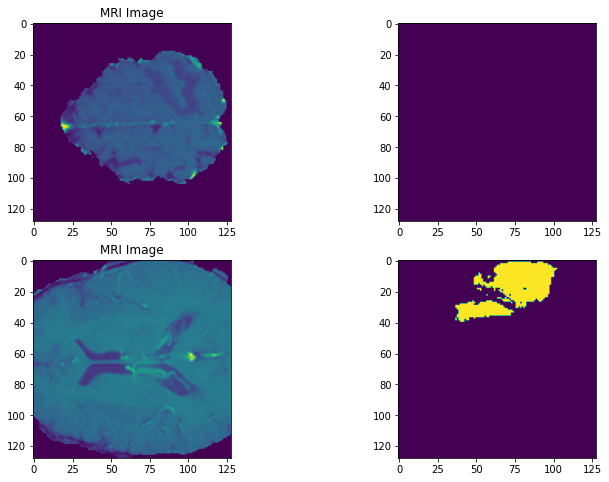

In [69]:
rand=np.random.randint(0,17203 )
rand_2=np.random.randint(0,4301)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('MRI Image')
plt.imshow(x_train[rand,:,:,0])
plt.subplot(222)
plt.imshow(y_train[rand,:,:,1])

plt.subplot(223)
plt.title('MRI Image')
plt.imshow(x_train[rand_2,:,:,0])
plt.subplot(224)
plt.imshow(y_train[rand_2,:,:,2])

plt.imshow

In [79]:
yy = y_train

In [80]:
yy.shape

(21504, 128, 128, 4)

In [81]:
yy = y_train[:,:,:,2]

In [82]:
yy.shape

(21504, 128, 128)

In [83]:
yy = np.expand_dims(yy, axis = 3)

In [84]:
yy.shape

(21504, 128, 128, 1)

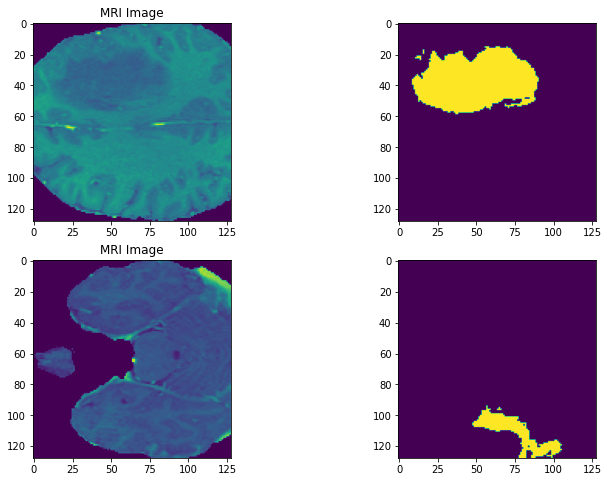

In [87]:
rand=np.random.randint(0,17203 )
rand_2=np.random.randint(0,4301)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('MRI Image')
plt.imshow(x_train[rand,:,:,0])
plt.subplot(222)
plt.imshow(yy[rand,:,:,0])

plt.subplot(223)
plt.title('MRI Image')
plt.imshow(x_train[rand_2,:,:,0])
plt.subplot(224)
plt.imshow(yy[rand_2,:,:,0])

In [88]:
y_train = yy

In [89]:
y_train.shape

(21504, 128, 128, 1)

In [90]:
del yy

In [128]:
#y_val = y_val[:,:,:,2]
y_val = np.expand_dims(y_val, axis = 3)
y_val.shape

(5376, 128, 128, 1)

In [129]:
img_rows = 128
img_cols = 128
channels = 1
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer, run_eagerly=True)

In [130]:
combined.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_17 (Functional)          (None, 128, 128, 1)  41837185    ['input_35[0][0]']               
                                                                                                  
 input_34 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                           

In [111]:
rand_ = random.randint(0,len(x_val))
rand_

3963

In [108]:
len(x_val)

5376

In [133]:
imgs_A, imgs_B = x_val[10:16,:,:,0], y_val[rand_,:,:,0]

In [134]:
imgs_A.shape, imgs_B.shape

((6, 128, 128), (128, 128))

In [114]:
def show_images(batch_i):
        
        r, c = 3, 3

        rand_ = random.randint(0,(len(x_val)-batch_i))

        imgs_A, imgs_B = x_val[rand_:rand_+batch_i,:,:,0], y_val[rand_:rand_+batch_i,:,:,0]
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [115]:
def train( dataset_name,epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name,batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            if epoch%10==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,epoch, batch_i)

In [ ]:
train("spade_data",epochs=50, batch_size=10, show_interval=10)